---

# CSCI 3202, Spring 2022
# Final Coding Exam
# Due: April 30, 2022 at 11:59 PM

<br> 

### Name: Evi Judge

<br> 

# CSCI 3202, Spring 2022: Final Coding Project

---


This is your final programming project for CSCI 3202. It is due on Canvas by **11:59 PM on Saturday April 30**.  Your solutions to theoretical questions should be done in Markdown/LateX directly below the associated question. Your solutions to computational questions should include any relevant Python code, as well as results and any written commentary.

You have two options for completing your final project for this course. The first option was presented in class and involves implementing a reinforcement learning algorithm and producing a five-minute video that explains your process of solving this problem. **The second option** is to design your own project that includes the algorithms we've discussed since the midterm - **Bayes Nets**, Hidden Markov Models, Markov Decision Processes, or Reinforcement Learning - or an algorithm related to one of these that we haven't discussed in class. Your project also needs to include **some kind of analysis of how it performed on a specific problem**. If you're interested in the design your own project option, you need to discuss your idea with one of the course instructors to get approval. If you do a project without getting approval, you will receive a 0 regardless of the quality of the project. **You will also need to produce a short, five-minute video that explains your project.**

**The rules:**

1. Choose EITHER the given problem to submit OR choose your own project topic. 

2. If you choose your own project topic, please adhere to the following guidelines:
- The project needs to be approved by the course instructors.
- The project needs to include one of the algorithms we've discussed since the midterm - **Bayes Nets**, HMMs, MDPs, or Reinforcement Learning - or an algorithm that we haven't discussed in class. 
- If you do your own project without prior approval, you will receive a 0 for this project.
- Your project code, explanation, and results must all be contained in a Jupyter notebook. 

3. All work, code and analysis must be **your own**.
4. You may use your course notes, posted lecture slides, textbook, in-class notebooks and homework solutions as resources.  You may also search online for answers to general knowledge questions, like the form of a probability distribution function, or how to perform a particular operation in Python. You may not use entire segments of code as solutions to any part of this project, e.g. if you find a Python implementation of policy iteration online, you can't use it.
5. You may **not** post to message boards or other online resources asking for help.
6. **You may not collaborate with classmates or anyone else.**
7. This is meant to be like a coding portion of your final exam. So, we will be much less helpful than we typically am with homework. For example, we will not check answers, help debug your code, and so on.
8. If you have a question, post it first as a **private** Piazza message. If we decide that it is appropriate for the entire class, then we will make it a public post (and anonymous).
9. If something is left open-ended, it is probably because we intend for you to code it up however you want, and only care about the plots/analysis we see at the end. Feel free to ask clarifying questions though.

Violation of these rules will result in an **F** and a trip to the Honor Code council.

---
**By writing your name below, you agree to abide by these rules:**

**Your name: Evi Judge**

---

Some useful packages and libraries:

In [1]:
from scipy import stats
import unittest
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from math import floor, isclose

## Background
***

The aim of this project to examine the factors that contribute to a person speaking Standard American English (SAE) or not through a Bayesian Network. The main factors that will be taken into account are whether the person has hearing loss (HL) and their socioeconomic background (based on household income that accounts for different racial and ethnic backgrounds). Hearing loss itself is also examined for conditioning factors of whether the person has a disorder or not and the individual's gender.

**Some initial thoughts:**
- Disorders are typically skewed towards having a higher prevalence in males - often due to genetic factors, where males receive XY chromosomes and females receive XX chromosomes.
    - The implication for males is that if the X-chromosome is damaged in anyway, this damage may realize itself as a disorder that affects the individual. 
    - For a female, if one X-chromosome is damaged, the damage is often less severe since there is still one more X-chromosome involved.
- Hearing loss will likely contribute to whether a person speaks SAE or not. Since the acquisition of speech requires an auditory feedback loop, the presence of hearing loss will impact the development of _spoken_ language.
- While socioeconomic status does _not_ play a causative role in language development, SES may contribute to the type of language to which a person is exposed. 

This Bayes net extends the solely Boolean variable nets that we examined in class. Similar to the extra credit problem on Homework-4, the Bayes net that follows uses four distinct bins for `Disorder` and three distinct bins for `SES` background. `Gender`, `Hearing Loss`, and `SAE` speaker still utilize binary bins.

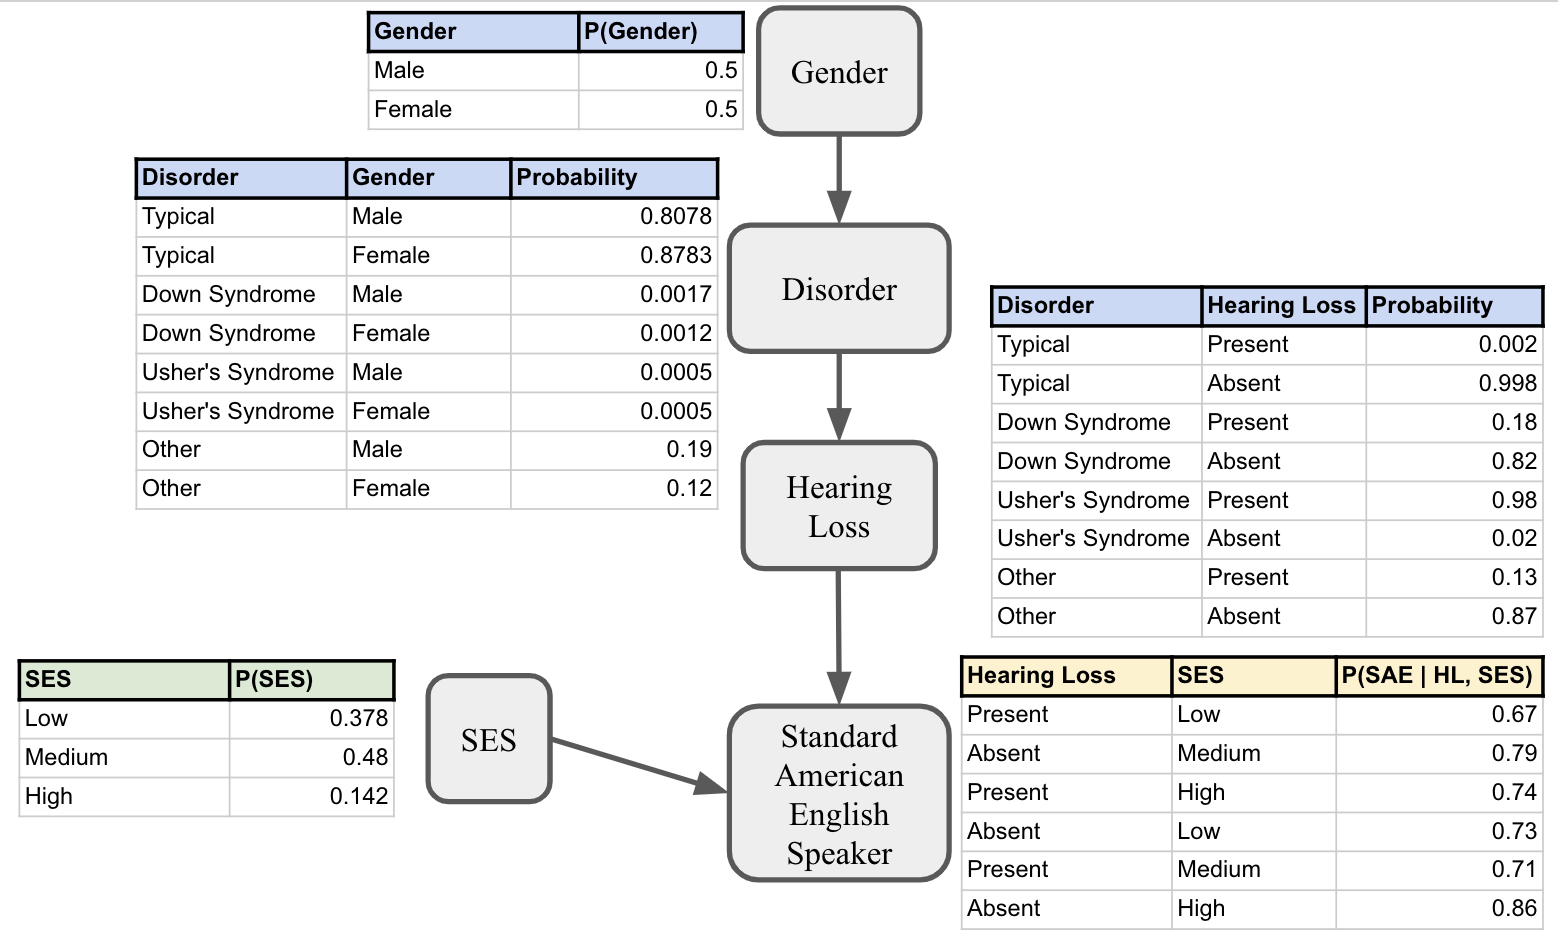

**Nodes & Bins**

- `Gender`: male (`M`), female (`F`)
    - Assumption is that population has a roughly equal distribution between the sexes.
- `Disorder`: typical (aka, no disorder - `nd`), Down Syndrome (`ds`), Usher's Syndrome (`us`), other (`o`)
    - Down Syndrome & Usher's Syndrome are both syndromes with a high incidence of hearing loss.
    - Note: "other" encompasses not only developmental disorders but includes mental and behavioral disorders as well.
- `Hearing Loss`: present (`pr`), absent (`ab`)
- `SES`: low (`low`), medium (`mid`), high (`high`)
- `SAE`: true (is a speaker, `true`), false (is not a speaker, `false`)
    - Please Note: SAE is an idealized version of English and an estimate of what the U.S. Census meant by the question, "Do you speak English 'very well' or 'less than very well'?" (https://www.census.gov/acs/www/about/why-we-ask-each-question/language/). From a descriptive linguist's standpoint, I would disagree with this measure of language; however, for the purpose of this model, SAE was the only suitable language for which I was able to find any substantial speaker data.

### `P` probability function:

This is code used in class on Friday (11 March) and in Homework-4.

In [2]:
## True/false abbreviations
T, F = True, False

def P(var, value, evidence={}):
    '''The probability distribution for P(var | evidence), 
    when all parent variables are known (in evidence)'''
#     print(f"\n---\nvar: {var}, value: {value}, evidence: {evidence}")
    if len(var.parents)==1:
        # only one parent
        row = evidence[var.parents[0]]
    else:
        # multiple parents
        row = tuple(evidence[parent] for parent in var.parents)

    if type(var.cpt[row]) == dict:
#         print(f"var.cpt[{row}]: {var.cpt[row]}")
        return var.cpt[row][value]
    else:
        if value == False:
            return 1-var.cpt[row]
        else:
            return var.cpt[row]

### Create `BayesNet` class:

1. The nodes are represented using the `BayesNode` class and can work with the `P` function for probabilities.
2. `BayesNet` class keeps track of nodes (parents/children) in the Bayes net.


In [3]:
##===============================================##
##                BayesNode class                ##
##===============================================##
class BayesNode:
    
    def __init__(self, name, parents, values, cpt):
        if isinstance(parents, str):
            parents = parents.split()
            
        if len(parents)==0:
            # if no parents, empty dict key for cpt
            cpt = {(): cpt}
        elif isinstance(cpt, dict):
            # if there is only one parent, only one tuple argument
            if cpt and isinstance(list(cpt.keys())[0], bool):
                cpt = {(v): p for v, p in cpt.items()}

        self.variable = name
        self.parents = parents
        self.cpt = cpt
        self.values = values
        self.children = []
        
    def __repr__(self):
        return repr((self.variable, ' '.join(self.parents)))    

    
##===============================================##
##                 BayesNet class                ##
##===============================================##

class BayesNet:
    '''Bayesian network containing only boolean-variable nodes.'''

    def __init__(self, nodes):
        '''Initialize the Bayes net by adding each of the nodes,
        which should be a list BayesNode class objects ordered
        from parents to children (`top` to `bottom`, from causes
        to effects)'''
        self.nodes = []
        self.variables = []
        for aspect in nodes:
            self.add(aspect)
                
    def add(self, node):
        '''Add a new BayesNode to the BayesNet. The parents should all
        already be in the net, and the variable itself should not be'''
#         print(f"node.variable: {node.variable} self.variables: {self.variables}")
        assert node.variable not in self.variables
        assert all((parent in self.variables) for parent in node.parents)
        
        self.nodes.append(node)
        self.variables.append(node.variable)
        
        for p in node.parents:
            self.find_node(p).children.append(node)
        
            
    def find_node(self, var):
        '''Find and return the BayesNode in the net with name `var`'''
        for n in self.nodes:
            if n.variable == var:
                return n
        raise Exception(f"No such variable: {var}")
        
        
    def find_values(self, var):
        '''Return the set of possible values for variable `var`'''
        varnode = self.find_node(var)
        return varnode.values
        
    
    def __repr__(self):
        return 'BayesNet({})'.format(self.nodes)

**Unit Tests**

- Perform the same unit tests as in Homework-4

In [4]:
class Tests_Problem1(unittest.TestCase):
    def setUp(self):
        self.p1 = BayesNode('p1', '', [T,F], 0.3)
        self.p2 = BayesNode('p2', '', [T,F], 0.6)
        self.c  = BayesNode('c', ['p1', 'p2'], [T,F], {(T,T):0.1, (T,F):0.2, (F,T):0.3, (F,F):0.4})
    def test_onenode(self):
        self.assertEqual(P(self.p1, T), 0.3)
    def test_twonode(self):
        self.assertEqual(P(self.c, F, {'p1':T, 'p2':F}), 0.8)

In [5]:
tests_to_run = unittest.TestSuite()
tests_to_run.addTest(Tests_Problem1("test_onenode"))
tests_to_run.addTest(Tests_Problem1("test_twonode"))
unittest.TextTestRunner().run(tests_to_run)

..
----------------------------------------------------------------------
Ran 2 tests in 0.001s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

Create `get_prob(X, e, bn)` to return the **normalized** probability distribution of variable `X` in the Bayes net, `bn`, given the evidence, `e`. This returns $P(X|e)$.

- `X` represents the variable I am looking for the probability distribution of. (`BayesNode` object or variable name)

- `e` represents the evidence the probability is conditioned on. If an empty argument or `None` is passed for `e`, the function should return the marginal distribution, $P(X)$.

- `bn` is the `BayesNet` object.

This is implemented with the `enumeration` algorithm from class.

In [6]:
## code from Lecture 25
class PDF_discrete:
    '''Define a discrete probability distribution function.'''

    def __init__(self, varname='?', freqs=None):
        '''Create a dictionary of values - frequency pairs,
        then normalize the distribution to sum to 1.'''
        self.prob = {}
        self.varname = varname
        self.values = []
        if freqs:
            for (v, p) in freqs.items():
                self[v] = p
        self.normalize()

    def __getitem__(self, value):
        '''Given a value, return P[value]'''
        try:
            return self.prob[value]
        except KeyError:
            return 0

    def __setitem__(self, value, p):
        '''Set P[value] = p, input argument if '''
        if value not in self.values:
            self.values.append(value)
        self.prob[value] = p

    def normalize(self):
        '''Normalize the probability distribution and return it.
        If the sum of PDF values is 0, then return a 0'''
        total = sum(self.prob.values())
        if not isclose(total, 1.0):
            for value in self.prob:
                self.prob[value] /= total
        return self
    
def extend(s, var, val):
    """Copy the substitution s and extend it by setting var to val; return copy."""
    s2 = s.copy()
    s2[var] = val
    return s2

In [7]:
def get_prob(X, e, bn): # goal: return normalized probability distribution of var X
    '''Return the conditional probability distribution of variable X
    given evidence e, from BayesNet bn. [Figure 14.9]'''
    if e == None:
        e = {}
    Q = PDF_discrete(X)
    for xi in bn.find_values(X):
            Q[xi] = enumerate_all(bn.variables, extend(e, X, xi), bn)
    return Q.normalize()

###
def enumerate_all(variables, e, bn): 
    if not variables:
        return 1.0
    Y, rest = variables[0], variables[1:]
    Ynode = bn.find_node(Y)
    if Y in e: # Y in evidence, so we know its value and just multiply
        return P(Ynode, e[Y], e) * enumerate_all(rest, e, bn)
    else: # Y is NOT in evidence, so we have to sum (Law of Total Probability)
        return sum(P(Ynode, y, e) * enumerate_all(rest, extend(e, Y, y), bn) for y in bn.find_values(Y))

## Create Bayes Net & Test `get_prob`:

Create a `BayesNet` and use the `get_prob` function to calculate the following probabilities. In order to compare them to the original Bayes net figure provided above, print these probabilities to the screen.

1. The marginal probability of being female $P(F) = 0.5$.
2. The marginal probability of medium socioeconomic status $P(SES_{medium}) = 0.48$.
3. The marginal probability of low socioeconmic status $P(SES_{low}) = 0.378$.
4. The probability of being typical (having no disorder, $
\texttt{ND}$) given you are male $P(\texttt{ND} | \texttt{male}) = 0.768$

In [8]:
## ---------------- Create the BayesNet nodes ------------------ ##
M, F = True, False # male & female
nd, ds, us, o = 'nd', 'ds', 'us', 'o' # typical, Down, Usher's, other
pr, ab = True, False # present, absent
low, mid, high = 'low', 'mid', 'high'
T, F = True, False # true, false speaker of SAE

## Create the following nodes: Gender, Disorder, HL, StandEng, SES
Gender = BayesNode('Gender', '', [M, F], 0.5)
Disorder = BayesNode('Disorder', ['Gender'], [nd, ds, us, o], {
    (M): { (nd):0.8078, (ds):0.0017, (us):0.0005, (o):0.19 },
    (F): { (nd):0.8783, (ds):0.0012, (us):0.0005, (o):0.12 }
})
HL = BayesNode('Hearing Loss', ['Disorder'], [ab, pr], {
    (nd): {(pr):0.002, (ab):0.998 },
    (ds): {(pr):0.18, (ab):0.82},
    (us): {(pr):0.98, (ab):0.02},
    (o): {(pr):0.13, (ab):0.87}
})
SES = BayesNode('SES', '', [low, mid, high], {
    (low): 0.378, (mid): 0.48, (high): 0.142
})
SAE = BayesNode('SAE', ['Hearing Loss', 'SES'], [T, F], {
    (pr,low): 0.67, (pr,mid): 0.71, (pr,high): 0.74,
    (ab,low): 0.73, (ab,mid): 0.79, (ab,high): 0.86 
})

## ---------------- Create the BayesNet nodes ------------------ ##
myBayes = BayesNet([Gender, Disorder, HL, SES, SAE])

In [9]:
p_female = get_prob(X='Gender', e=None, bn=myBayes)
print(f"P(Gender=F): {p_female[False]:.5f}")

p_ses = get_prob(X='SES', e=None, bn=myBayes)
print(f"P(SES=medium): {p_ses['mid']:.5f}")
print(f"P(SES=low): {p_ses['low']:.5f}")

p_NDmale = get_prob(X='Disorder', e={'Gender':M}, bn=myBayes)
print(f"P(ND|male): {p_NDmale['nd']:.5f}")

P(Gender=F): 0.50000
P(SES=medium): 0.48000
P(SES=low): 0.37800
P(ND|male): 0.80780


**Calculate** the following probabilities using the `get_prob` function.

1. The probability distribution of having a disorder or being typical, that is $P(Disorder)$. 

In [10]:
p_disorder = get_prob(X='Disorder', e=None, bn=myBayes)

print(f"P(Disorder): [Down Syndrome: {p_disorder['ds']:.5f}, Usher's Syndrome: {p_disorder['us']:.5f}, "
          f"Other: {p_disorder['o']:.5f}, Typical: {p_disorder['nd']:.5f}]")

P(Disorder): [Down Syndrome: 0.00145, Usher's Syndrome: 0.00050, Other: 0.15500, Typical: 0.84305]


**Verify** the probability distribution in $\texttt{(1)}$ by hand:

$P(disorder) = \sum_{Gender} P(Disorder | Gender) * P(Gender)$
***
$P(Gender = male) = 0.5$
$P(Gender = female) = 0.5$
***
**Down Syndrome**: 

$P(Down Syndrome) = \sum_{Gender} P(Down Syndrome | Gender) * P(Gender)$
    $$= P(ds | male)*P(male) + P(ds|female)*P(female)$$
    $$= (0.0017*0.5)+(0.0012*0.5) = 0.00085+0.0006 =0.00145$$

**Usher's Syndrome**: 

$P(Usher's Syndrome) = \sum_{Gender} P(Usher's Syndrome | Gender) * P(Gender)$
    $$= P(us | male)*P(male) + P(us|female)*P(female)$$
    $$= (0.0005*0.5)+(0.0005*0.5) = 0.00025+0.00025 =0.0005$$

**Other disorder**: 

$P(Other) = \sum_{Gender} P(Other | Gender) * P(Gender)$
    $$= P(o | male)*P(male) + P(o|female)*P(female)$$
    $$= (0.19*0.5)+(0.12*0.5) = 0.095+0.06 =0.155$$

**No disorder**: 

$P(No disorder) = \sum_{Gender} P(No disorder | Gender) * P(Gender)$
    $$= P(nd | male)*P(male) + P(nd|female)*P(female)$$
    $$= (0.8078*0.5)+(0.8783*0.5) = 0.4039+0.43915 =0.84305$$
***
$P(Disorder) = [ds: 0.00145, us: 0.0005, o: 0.155, nd: 0.84305]$

- To check this distrubution, the summation of the distribution should equal $1$.
    - $\sum_{P(Disorder)} = 0.00145 + 0.0005 + 0.155 + 0.84305 = 1.0$

2. The probability distribution of hearing loss. $P(Hearing Loss)$ And the probability of HL given gender. $P(HL| Gender)$

In [11]:
p_HL = get_prob(X='Hearing Loss', e=None, bn=myBayes)
print(f"P(Hearing Loss): [present: {p_HL[pr]:.5f}, absent: {p_HL[ab]:.5f}]")

p_HLmale = get_prob(X='Hearing Loss', e={'Gender':M}, bn=myBayes)
print(f"--\nP(HL | male): {p_HLmale[pr]:.5f}")

p_HLfemale = get_prob(X='Hearing Loss', e={'Gender':F}, bn=myBayes)
print(f"P(HL | female): {p_HLfemale[pr]:.5f}")

P(Hearing Loss): [present: 0.02259, absent: 0.97741]
--
P(HL | male): 0.02711
P(HL | female): 0.01806


**Comment** on the probabilities observed in $\texttt(2)$:

- The probability distribution of hearing loss indicates that it is more likely ($0.977$) that an individual does not have hearing loss.
    - The probability of hearing loss ($0.0226$) from my Bayes net is slightly elevated from what the CDC estimates ($1$ to $5$ in $1,000$ children, https://www.cdc.gov/ncbddd/hearingloss/research.html). This could be from inconsistency in the sources that I combined to form my initial probabilities.
- In examining hearing loss given gender, males are about $1%$ more likely to have hearing loss than females - this is likely related to the small skew in males who have Down Syndrome (the parent node to `Hearing Loss`).

3. The probability that an individual is male/female, given hearing loss and disorder (Down Syndrome, Usher's Syndrome, Other disorder, or typical). $P(Gender | HL=present, Disorder)$

In [12]:
## Down Syndrome Probabilties
p_genderHLds = get_prob(X='Gender', e={'Hearing Loss':pr, 'Disorder':ds}, bn=myBayes)
print(f"P(Male | HL, Down Syndrome): {p_genderHLds[M]:.5f}")
print(f"\tP(Female | HL, Down Syndrome): {p_genderHLds[F]:.5f}")

## Usher's Syndrome Probabilities
p_genderHLus = get_prob(X='Gender', e={'Hearing Loss':pr, 'Disorder':us}, bn=myBayes)
print(f"P(Male | HL, Usher's Syndrome): {p_genderHLus[M]:.5f}")
print(f"\tP(Female | HL, Usher's Syndrome): {p_genderHLus[F]:.5f}")

## Other disorder Probabilities
p_genderHLo = get_prob(X='Gender', e={'Hearing Loss':pr, 'Disorder':o}, bn=myBayes)
print(f"P(Male | HL, other): {p_genderHLo[M]:.5f}")
print(f"\tP(Female | HL, other): {p_genderHLo[F]:.5f}")

## Typical (no disorder) Probabilities
p_genderHLnd = get_prob(X='Gender', e={'Hearing Loss':pr, 'Disorder':nd}, bn=myBayes)
print(f"P(Male | HL, no disorder): {p_genderHLnd[M]:.5f}")
print(f"\tP(Female | HL, no disorder): {p_genderHLnd[F]:.5f}")

P(Male | HL, Down Syndrome): 0.58621
	P(Female | HL, Down Syndrome): 0.41379
P(Male | HL, Usher's Syndrome): 0.50000
	P(Female | HL, Usher's Syndrome): 0.50000
P(Male | HL, other): 0.61290
	P(Female | HL, other): 0.38710
P(Male | HL, no disorder): 0.47909
	P(Female | HL, no disorder): 0.52091


**Comment** on the probabilities observed in $\texttt(3)$:

- In either case of Down Syndrome or Other disorder being observed (in addition to hearing loss), there is a higher probability that the individual is male. This is expected since the probability of having either of these disorders is higher for males: in the original Bayes net - 

```
P(Down Syndrome | Gender) = [M=0.0017, F=0.0012]
P(Other disorder | Gender) = [M=0.19, F=0.12]
```

- Since Usher's Syndrome does not have this gender skew, it is expected that hearing loss co-occurring with Usher's would result in equal probabilities observed for both males and females.
- Initially, I found it surprising that given hearing loss and _no_ disorder, there is a higher probability that the individual is female. However, after some thought, this is the same observation as described in the first bullet point: since there is a greater percentage of typical females, if hearing loss does occur, then the probability of being female is inflated too.  

4. The probability distribution of speakers of SAE. $P(SAE)$ And the probability distribution of speakers of SAE given both hearing loss and SES. $P(SAE | HL, SES)$ (This should be the same as the `SAE` node in the Bayes net above.)

In [13]:
## SAE alone
p_SAE = get_prob(X='SAE', e=None, bn=myBayes)
print(f"P(SAE speaker): [yes: {p_SAE[T]:.5f}, no: {p_SAE[F]:.5f}]")

## ------------------------- SAE given HL=pr & SES --------------------------- ##
## HL & Low SES
p_hlSAElow = get_prob(X='SAE', e={'SES': low, 'Hearing Loss':pr}, bn=myBayes)
print(f"--\nP(SAE=T | SES=low, HL=present): {p_hlSAElow[T]:.5f}")
print(f"\tP(SAE=F | SES=low, HL=present): {p_hlSAElow[F]:.5f}")

## HL & Medium SES
p_hlSAEmid = get_prob(X='SAE', e={'SES': mid, 'Hearing Loss':pr}, bn=myBayes)
print(f"P(SAE=T | SES=mid, HL=present): {p_hlSAEmid[T]:.5f}")
print(f"\tP(SAE=F | SES=mid, HL=present): {p_hlSAEmid[F]:.5f}")

## HL & High SES
p_hlSAEhigh = get_prob(X='SAE', e={'SES': high, 'Hearing Loss':pr}, bn=myBayes)
print(f"P(SAE=T | SES=high, HL=present): {p_hlSAEhigh[T]:.5f}")
print(f"\tP(SAE=F | SES=high, HL=present): {p_hlSAEhigh[F]:.5f}")

## ------------------------- SAE given HL=ab & SES --------------------------- ##
## HL & Low SES
p_hlABSAElow = get_prob(X='SAE', e={'SES': low, 'Hearing Loss':ab}, bn=myBayes)
print(f"--\nP(SAE=T | SES=low, HL=absent): {p_hlABSAElow[T]:.5f}")
print(f"\tP(SAE=F | SES=low, HL=absent): {p_hlABSAElow[F]:.5f}")

## HL & Medium SES
p_hlABSAEmid = get_prob(X='SAE', e={'SES': mid, 'Hearing Loss':ab}, bn=myBayes)
print(f"P(SAE=T | SES=mid, HL=absent): {p_hlABSAEmid[T]:.5f}")
print(f"\tP(SAE=F | SES=mid, HL=absent): {p_hlABSAEmid[F]:.5f}")

## HL & High SES
p_hlABSAEhigh = get_prob(X='SAE', e={'SES': high, 'Hearing Loss':ab}, bn=myBayes)
print(f"P(SAE=T | SES=high, HL=absent): {p_hlABSAEhigh[T]:.5f}")
print(f"\tP(SAE=F | SES=high, HL=absent): {p_hlABSAEhigh[F]:.5f}")

P(SAE speaker): [yes: 0.77550, no: 0.22450]
--
P(SAE=T | SES=low, HL=present): 0.67000
	P(SAE=F | SES=low, HL=present): 0.33000
P(SAE=T | SES=mid, HL=present): 0.71000
	P(SAE=F | SES=mid, HL=present): 0.29000
P(SAE=T | SES=high, HL=present): 0.74000
	P(SAE=F | SES=high, HL=present): 0.26000
--
P(SAE=T | SES=low, HL=absent): 0.73000
	P(SAE=F | SES=low, HL=absent): 0.27000
P(SAE=T | SES=mid, HL=absent): 0.79000
	P(SAE=F | SES=mid, HL=absent): 0.21000
P(SAE=T | SES=high, HL=absent): 0.86000
	P(SAE=F | SES=high, HL=absent): 0.14000


5. The probability that an individual is an SAE speaker, given that the individual has hearing loss. $P(SAE | HL=present)$ 

In [14]:
## SAE given just HL
p_SAEpr = get_prob(X='SAE', e={'Hearing Loss': pr}, bn=myBayes)
print(f"P(SAE=T | HL=present): {p_SAEpr[T]:.5f}")
print(f"\tP(SAE=F | HL=present): {p_SAEpr[F]:.5f}")

p_SAEab = get_prob(X='SAE', e={'Hearing Loss': ab}, bn=myBayes)
print(f"P(SAE=T | HL=absent): {p_SAEab[T]:.5f}")
print(f"\tP(SAE=F | HL=absent): {p_SAEab[F]:.5f}")

P(SAE=T | HL=present): 0.69914
	P(SAE=F | HL=present): 0.30086
P(SAE=T | HL=absent): 0.77726
	P(SAE=F | HL=absent): 0.22274


6. The probability that an individual is an SAE speaker, given the individual's SES background (low, medium, high). $P(SAE | SES)$ 

In [15]:
## Low SES
p_SAElow = get_prob(X='SAE', e={'SES': low}, bn=myBayes)
print(f"P(SAE=T | SES=low): {p_SAElow[T]:.5f}")
print(f"\tP(SAE=F | SES=low): {p_SAElow[F]:.5f}")

## Medium SES
p_SAEmid = get_prob(X='SAE', e={'SES': mid}, bn=myBayes)
print(f"P(SAE=T | SES=mid): {p_SAEmid[T]:.5f}")
print(f"\tP(SAE=F | SES=mid): {p_SAEmid[F]:.5f}")

## High SES
p_SAEhigh = get_prob(X='SAE', e={'SES': high}, bn=myBayes)
print(f"P(SAE=T | SES=high): {p_SAEhigh[T]:.5f}")
print(f"\tP(SAE=F | SES=high): {p_SAEhigh[F]:.5f}")

P(SAE=T | SES=low): 0.72864
	P(SAE=F | SES=low): 0.27136
P(SAE=T | SES=mid): 0.78819
	P(SAE=F | SES=mid): 0.21181
P(SAE=T | SES=high): 0.85729
	P(SAE=F | SES=high): 0.14271


**Comment** on the probabilities observed in $\texttt(4)$, $\texttt(5)$, and $\texttt(6)$:

- The probability that an individual is an SAE speaker seems to be more greatly affected by whether they have hearing loss than the individual's economic status. Given each economic status, the likelihood of an individual speaking Standard American English increases. 
    - And looking at both low SES and HL presence, there is a greater likelihood that a person of low SES will speak SAE than a person with just hearing loss. 
- The relationship of `SAE`, `Hearing Loss`, and `SES` represents a cannonical effect of **common effect**. `SAE`'s parent nodes are `Hearing Loss` and `SES`, so when `SAE`'s probability distribution is examined without its parents (as in $\texttt(4)$ it is higher than when either HL or SES are conditioned. The probability of `SAE` given `Hearing Loss` and/or `SES` decreases because of the competition between the parent nodes. 

7. The probability distribution of hearing loss given that the individual speaks SAE. $P(HL | SAE=T)$ Given that the individual speaks SAE and their SES background? $P(HL | SAE, SES)$

In [16]:
## P(HL | SAE=T)
p_hlSAE = get_prob(X='Hearing Loss', e={'SAE': T}, bn=myBayes)
print(f"P(HL | SAE=T): [present: {p_hlSAE[pr]:.5f}, absent: {p_hlSAE[ab]:.5f}]")

## ---------------------- P(HL | SAE=T, SES=[low,medium,high]) ----------------------- ##
## SAE=T, SES=low
p_hlSAElow = get_prob(X='Hearing Loss', e={'SAE': T, 'SES':low}, bn=myBayes)
print(f"--\nP(HL | SAE=T, SES=low): [present: {p_hlSAElow[pr]:.5f}, absent: {p_hlSAElow[ab]:.5f}]")

## SAE=T, SES=medium
p_hlSAEmid = get_prob(X='Hearing Loss', e={'SAE': T, 'SES':mid}, bn=myBayes)
print(f"P(HL | SAE=T, SES=mid): [present: {p_hlSAEmid[pr]:.5f}, absent: {p_hlSAEmid[ab]:.5f}]")

## SAE=T, SES=high
p_hlSAEhigh = get_prob(X='Hearing Loss', e={'SAE': T, 'SES':high}, bn=myBayes)
print(f"P(HL | SAE=T, SES=high): [present: {p_hlSAEhigh[pr]:.5f}, absent: {p_hlSAEhigh[ab]:.5f}]")

## ---------------------- P(HL | SES=[low,medium,high]) ----------------------- ##
## SES=low
p_hllow = get_prob(X='Hearing Loss', e={'SES':low}, bn=myBayes)
print(f"--\nP(HL | SES=low): [present: {p_hllow[pr]:.5f}, absent: {p_hllow[ab]:.5f}]")

## SES=medium
p_hlmid = get_prob(X='Hearing Loss', e={'SES':mid}, bn=myBayes)
print(f"P(HL | SES=mid): [present: {p_hlmid[pr]:.5f}, absent: {p_hlmid[ab]:.5f}]")

## SAE=T, SES=high
p_hlhigh = get_prob(X='Hearing Loss', e={'SES':high}, bn=myBayes)
print(f"P(HL | SES=high): [present: {p_hlhigh[pr]:.5f}, absent: {p_hlhigh[ab]:.5f}]")

P(HL | SAE=T): [present: 0.02036, absent: 0.97964]
--
P(HL | SAE=T, SES=low): [present: 0.02077, absent: 0.97923]
P(HL | SAE=T, SES=mid): [present: 0.02035, absent: 0.97965]
P(HL | SAE=T, SES=high): [present: 0.01950, absent: 0.98050]
--
P(HL | SES=low): [present: 0.02259, absent: 0.97741]
P(HL | SES=mid): [present: 0.02259, absent: 0.97741]
P(HL | SES=high): [present: 0.02259, absent: 0.97741]


**Comment** on the probabilities observed in $\texttt(7)$:

- Given that the individual speaks SAE, it is more probable that the individual does not have hearing loss ($0.9796$).
- When both SAE and SES are considered, the presence or absence of an individual having hearing loss does not change greatly. This means that SES is unrelated to hearing loss occurring in an individual.
    - HL is independent of SES as demonstrated in the last set of probabilities, where the probability of hearing loss, given solely SES is measured.

***
# Discussion

**Limitations**

The Bayes net is limited by the data it is fed. By that, I mean that if the data that one adds to the Bayes net is inaccurate, then one may expect to receive inaccurate results/probabilities. I found it difficult to find consistent data that I wanted to feed to the net - especially, with regard to the `SAE` node. I would have preferred to examine language acquisition as the final node to which `Hearing Loss` and `SES` condition went, but it was exceedingly difficult to find accurate numbers regarding the number of American Sign Language (ASL) users. I found too as I went that I began looking at `Disorders` more as a broad category of "does _anyone_ have a disorder" - this is different from the original position that I wanted to explore, which was that of only children, the prevalence of disability/disorder at birth, and language acquisition. The data that I found seemed to be a mix of school-aged children and babies, so I decided to broaden the scope of what "disorder" meant to me. 

***
# Conclusion

I believe that the Bayes net is a good way to model predicted outcomes for hearing loss and language based on prior data. I would use a Bayes net to build an initial model from which I could compare actual data, if I were to research this topic. I think that as a researcher it is sometimes difficult to know if one's collected data "makes sense" - the Bayes net seems to offer a solution to this problem because it models what one might expect based on prior data.

The primary findings that my Bayes net revealed to me are that...
1. If hearing loss is observed, there is only a slightly higher probability that the individual is male as opposed to female.
2. Whether or not an individual has hearing loss affects the probability that the individual will speak SAE.
3. The probability of being an SAE speaker is more strongly conditioned by the presence or absence of hearing loss and less strongly conditioned by the SES status of the individual.
    - The interaction of hearing loss and SES background created a common effect case on speaking Standard American English. This means that there is competition between HL and SES, so when SAE is conditioned both by HL and SAE ($P(SAE | HL, SES)$) the probability of being a speaker is lowered than if just HL ($P(SAE | HL)$) or just SAE ($P(SAE | SES)$) were examined in isolation.

## Sources:
***

The following sources were used in creating the original Bayes Net conditional probability tables:

### `Disorder`

**Typical/Other**
- Mental, behavioral, and/or developmental disorder (17.4%)
    - https://www.cdc.gov/childrensmentalhealth/data.html#ref 
- Higher incidence in males to have MBDDs (mental, behavior, developmental disorders)
    - https://www.cdc.gov/ncbddd/childdevelopment/features/key-finding-factors-mental-behavioral-developmental-early-childhood.html 
- Children with special health care needs (CSHCN)
    - https://mchb.hrsa.gov/sites/default/files/mchb/data-research/nsch-cshcn-context-09-2011.pdf 
    - https://mchb.hrsa.gov/sites/default/files/mchb/data-research/nsch-health-well-child-06-2014.pdf

**Down Syndrome**
- Male to female ratio ~1.3
    - https://pubmed.ncbi.nlm.nih.gov/2960497/#:~:text=In%20a%20sample%20of%2075,(p%20greater%20than%200.05).
    - https://www.disabilityscoop.com/2009/11/30/down-syndrome-prevalence/6320/ (no reference, but prevalence is higher in males)
- Overall, 0.0014% of births
    - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4445685/#:~:text=Most%20recently%2C%20Parker%20et%20al,per%2010%20000%20live%20births. 
    
**Usher's Syndrome**
- Rare autosomal disorder
    - https://www.nidcd.nih.gov/health/usher-syndrome (autosomal => men/women equally likely to get it)
- Types 1 & 2 are more prevalent (Type 3 ~2%) and have HL present at birth
    - https://medlineplus.gov/genetics/condition/usher-syndrome/#frequency (Type 3 has progressive HL)

### `Hearing Loss`
- Prevalence of HL with a syndrome
    - https://www.cdc.gov/ncbddd/hearingloss/data.html
    - Down syndrome:
        - https://www.jpeds.com/article/S0022-3476(14)01029-4/fulltext#:~:text=From%20a%20sample%20of%20109,be%20as%20high%20as%2022%25
- Nonsyndromic HL:
    - https://medlineplus.gov/genetics/condition/nonsyndromic-hearing-loss/#synonyms (~0.002%)
- Other HL:
    - https://www.nidcd.nih.gov/health/statistics/quick-statistics-hearing#:~:text=One%20in%20eight%20people%20in,based%20on%20standard%20hearing%20examinations.&text=About%202%20percent%20of%20adults,54%20have%20disabling%20hearing%20loss. (quick/rough HL stats)


### `SES`
- Table A-2:
    - https://www.census.gov/library/publications/2021/demo/p60-273.html 
    - Income Groups:
        - https://money.usnews.com/money/personal-finance/family-finance/articles/where-do-i-fall-in-the-american-economic-class-system
        - Low < $\$$52,200; middle $\$$52,200-156,600; upper > $\$$156,600
        - I overlaid these class distributions over the Census Table to estimate percentages for SES background.

### `SAE`
- Consider people who don't speak English at home (~21.5%)
    - https://www.census.gov/acs/www/about/why-we-ask-each-question/language/
    - SAE vs any dialect "less than standard"
    - Of 21.5%, 13.2% are Spanish-speaking

**Link to 5-min video if Canvas submission doesn't work for some reason:**
Topic: Evi Judge's Personal Meeting Room
Date: Apr 27, 2022 08:36 PM Mountain Time (US and Canada)

Meeting Recording:
https://cuboulder.zoom.us/rec/share/2oc6DKjiIhZEPlTc7cZWd6dG3A_9JklwywZJX7MyyRoIwQXpWy9oqi7pAziFtCmL.ywjDQHaEA6EhDa8K
